Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta

def week_year_to_date(year, week):
    starting_date = datetime(int(year), 1, 1)
    return starting_date + timedelta(int(week)*7-7)

Loading Data

In [13]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Adding Features

In [14]:
df_grouped = df.groupby(['longitude', 'latitude'])
lst = []
for name, group_df in df_grouped:
    group_df['rolling_emission3'] = group_df['emission'].rolling(window = 3, center = True).mean()
    group_df['rolling_emission5'] = group_df['emission'].rolling(window = 5, center = True).mean()
    group_df['rolling_emission7'] = group_df['emission'].rolling(window = 7, center = True).mean()
    group_df['rolling_emission9'] = group_df['emission'].rolling(window = 9, center = True).mean()
    group_df = group_df.interpolate(method='linear', limit_direction='both')
    lst.append(group_df)
df = pd.concat(lst)

last_year_df = (df
                .assign(year=df['year'] + 1)
                .loc[:, ['year', 'week_no', 'longitude', 'latitude', 'emission', 'rolling_emission3', 'rolling_emission5', 'rolling_emission7','rolling_emission9']]
                .rename(columns={'emission': 'last_year_emission'
                                 , 'rolling_emission3': 'ly_rolling_emission3'
                                 , 'rolling_emission5': 'ly_rolling_emission5'
                                 , 'rolling_emission7': 'ly_rolling_emission7'
                                 , 'rolling_emission9': 'ly_rolling_emission9'}))
df = pd.merge(df, last_year_df, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df['date'] =  df.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

Selecting Features

In [15]:
date_start = datetime(2020, 3, 1)
date_end = datetime(2020, 9, 30)
df = (df
      .query("year != 2019")
      .query("date < @date_start or date > @date_end")
      .loc[:, ['year'
               , 'week_no'
               , 'last_year_emission'
               , 'ly_rolling_emission3'
               , 'ly_rolling_emission5'
               , 'ly_rolling_emission7'
               , 'ly_rolling_emission9'
               , 'emission']])

Training Model

Mean Squared Error: 85.96354990884072
SD Error:  4.201363150496701


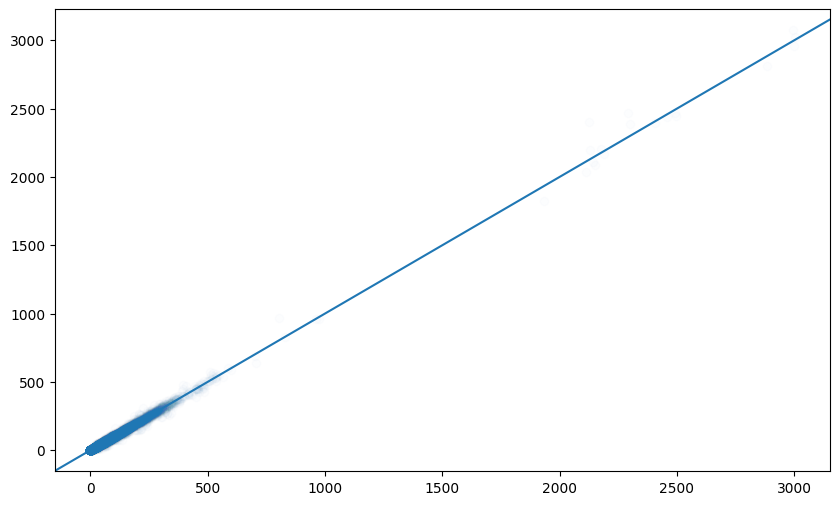

[0.00759    0.00641368 0.08184    0.794891   0.08291631 0.01153974
 0.01480929]


In [17]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['emission']), df.emission, test_size = .2)
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
se = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', se)
plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test, alpha = .01)
plt.axline((0, 0), slope=1)
plt.show()
print(model.feature_importances_)

Produce Training Results

In [10]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test['emission'] = np.nan

df = pd.concat([df_train, df_test])

df_grouped = df.groupby(['longitude', 'latitude'])
lst = []
for name, group_df in df_grouped:
    group_df['rolling_emission3'] = group_df['emission'].rolling(window = 3, center = True).mean()
    group_df['rolling_emission5'] = group_df['emission'].rolling(window = 5, center = True).mean()
    group_df['rolling_emission7'] = group_df['emission'].rolling(window = 7, center = True).mean()
    group_df['rolling_emission9'] = group_df['emission'].rolling(window = 9, center = True).mean()
    group_df = group_df.interpolate(method='linear', limit_direction='both')
    lst.append(group_df)
df = pd.concat(lst)

last_year_df = (df
                .assign(year=df['year'] + 1)
                .loc[:, ['year', 'week_no', 'longitude', 'latitude', 'emission', 'rolling_emission3', 'rolling_emission5', 'rolling_emission7','rolling_emission9']]
                .rename(columns={'emission': 'last_year_emission'
                                 , 'rolling_emission3': 'ly_rolling_emission3'
                                 , 'rolling_emission5': 'ly_rolling_emission5'
                                 , 'rolling_emission7': 'ly_rolling_emission7'
                                 , 'rolling_emission9': 'ly_rolling_emission9'}))
df = pd.merge(df, last_year_df, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df['date'] =  df.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

date_start = datetime(2020, 3, 1)
date_end = datetime(2020, 9, 30)
df = (df
      .query("year != 2019")
      .query("date < @date_start or date > @date_end")
      .loc[:, ['year'
               , 'week_no'
               , 'last_year_emission'
               , 'ly_rolling_emission3'
               , 'ly_rolling_emission5'
               , 'ly_rolling_emission7'
               , 'ly_rolling_emission9'
               , 'emission']])

x_train = df.query("year != 2022").drop(columns = ['emission']) 
x_test = df.query("year == 2022").drop(columns = ['emission']) 
y_train = df.query("year != 2022").emission
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

final_result = pd.DataFrame({
    'longitude': df_test['longitude'],
    'latitude': df_test['latitude'],
    'year': df_test['year'],
    'week_no': df_test['week_no'],
    'emission': y_pred
})


Write File

In [11]:
id_table = (pd.read_csv('test.csv')
            .loc[:, ['longitude', 'latitude', 'year', 'week_no', 'ID_LAT_LON_YEAR_WEEK']])
export = (pd.merge(final_result, id_table, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
            .loc[:, ['ID_LAT_LON_YEAR_WEEK', 'emission']])
export.to_csv('submission_3.csv', index=False)